# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    up_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    cc_layer = layers.concatenate([up_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    conv_1 = separable_conv2d_batchnorm(cc_layer, filters)
    output_layer = separable_conv2d_batchnorm(conv_1, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [24]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    ec_1 = encoder_block(inputs, 32, 2)
    ec_2 = encoder_block(ec_1, 48, 2)
    ec_3 = encoder_block(ec_2, 64, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1x1 = conv2d_batchnorm(ec_3, 64, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dc_3 = decoder_block(conv_1x1, ec_2, 64)
    dc_2 = decoder_block(dc_3, ec_1, 48)
    dc_1 = decoder_block(dc_2, inputs, 32)
    
    x = dc_1
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [27]:
num_training_samples = 6592
num_valid_samples = 1185

batch_size = 64
num_epochs = 100
learning_rate = 0.1
decay_rate = learning_rate / num_epochs

steps_per_epoch = num_training_samples/batch_size
validation_steps = num_valid_samples/batch_size
workers = 4

Epoch 1/100
102/103 [============================>.] - ETA: 0s - loss: 0.0925

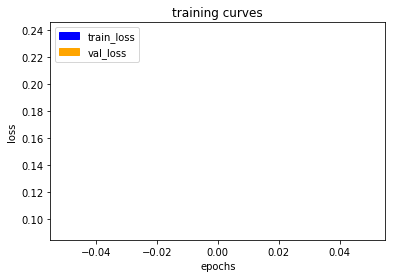

103/103 [==============================] - 68s - loss: 0.0921 - val_loss: 0.2384
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 0.0551

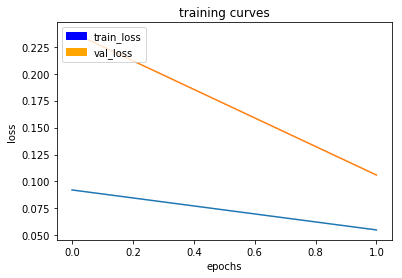

103/103 [==============================] - 67s - loss: 0.0550 - val_loss: 0.1060
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 0.0498

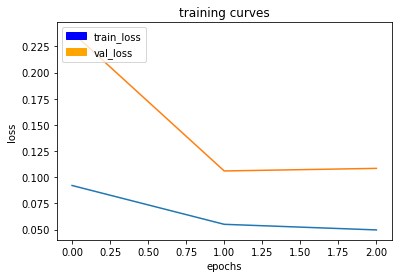

103/103 [==============================] - 67s - loss: 0.0497 - val_loss: 0.1085
Epoch 4/100
102/103 [============================>.] - ETA: 0s - loss: 0.0449

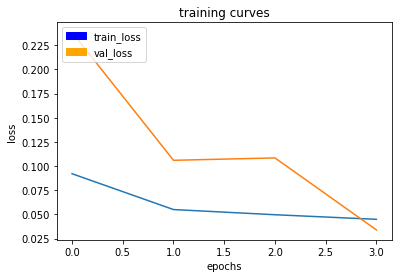

103/103 [==============================] - 67s - loss: 0.0449 - val_loss: 0.0340
Epoch 5/100
102/103 [============================>.] - ETA: 0s - loss: 0.0388

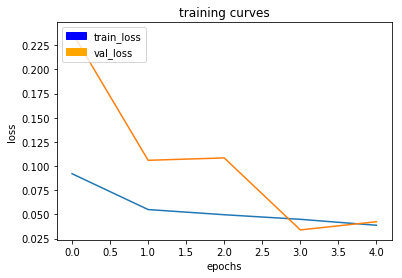

Epoch 00004: saving model to ./model-checkpoint/weights-e04-0.04.hdf5
103/103 [==============================] - 67s - loss: 0.0388 - val_loss: 0.0424
Epoch 6/100
102/103 [============================>.] - ETA: 0s - loss: 0.0352

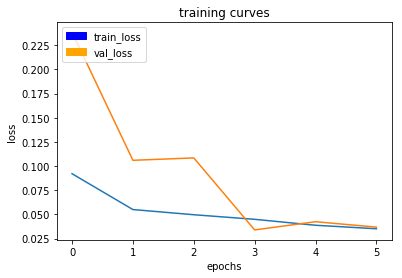

103/103 [==============================] - 68s - loss: 0.0352 - val_loss: 0.0369
Epoch 7/100
102/103 [============================>.] - ETA: 0s - loss: 0.0328

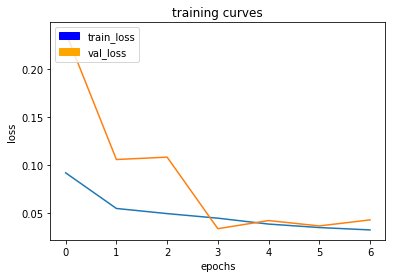

103/103 [==============================] - 67s - loss: 0.0327 - val_loss: 0.0431
Epoch 8/100
102/103 [============================>.] - ETA: 0s - loss: 0.0337

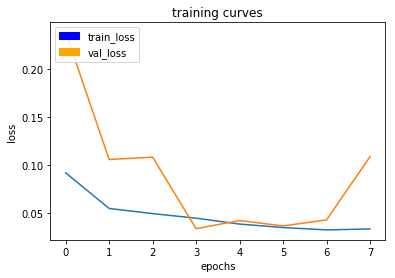

103/103 [==============================] - 67s - loss: 0.0337 - val_loss: 0.1090
Epoch 9/100
102/103 [============================>.] - ETA: 0s - loss: 0.0312

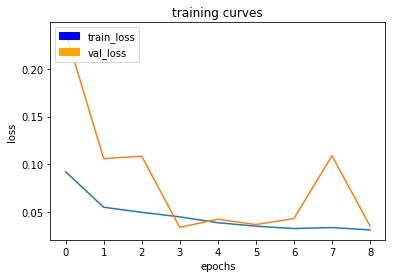

103/103 [==============================] - 67s - loss: 0.0313 - val_loss: 0.0355
Epoch 10/100
102/103 [============================>.] - ETA: 0s - loss: 0.0301

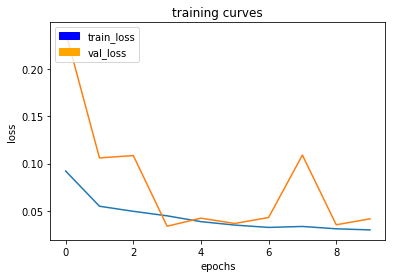

Epoch 00009: saving model to ./model-checkpoint/weights-e09-0.04.hdf5
103/103 [==============================] - 67s - loss: 0.0301 - val_loss: 0.0418
Epoch 11/100
102/103 [============================>.] - ETA: 0s - loss: 0.0290

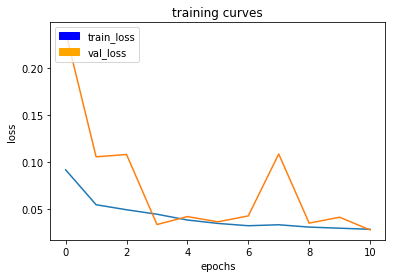

103/103 [==============================] - 67s - loss: 0.0289 - val_loss: 0.0283
Epoch 12/100
102/103 [============================>.] - ETA: 0s - loss: 0.0281

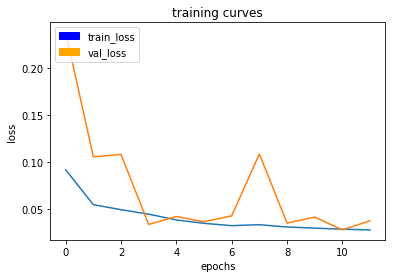

103/103 [==============================] - 66s - loss: 0.0282 - val_loss: 0.0379
Epoch 13/100
102/103 [============================>.] - ETA: 0s - loss: 0.0276

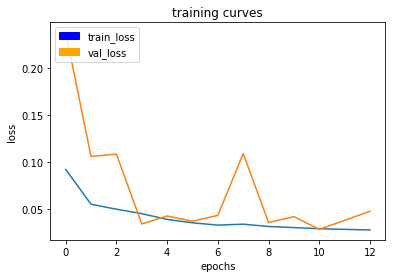

103/103 [==============================] - 67s - loss: 0.0276 - val_loss: 0.0474
Epoch 14/100
102/103 [============================>.] - ETA: 0s - loss: 0.0265

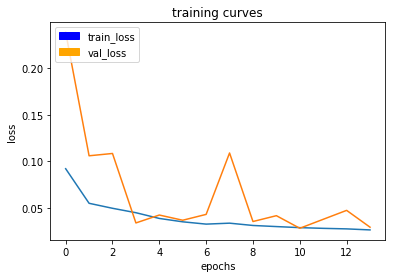

103/103 [==============================] - 67s - loss: 0.0265 - val_loss: 0.0294
Epoch 15/100
102/103 [============================>.] - ETA: 0s - loss: 0.0280

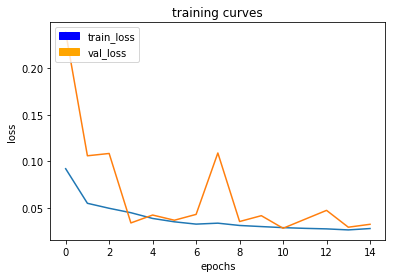

Epoch 00014: saving model to ./model-checkpoint/weights-e14-0.03.hdf5
103/103 [==============================] - 68s - loss: 0.0280 - val_loss: 0.0325
Epoch 16/100
102/103 [============================>.] - ETA: 0s - loss: 0.0254

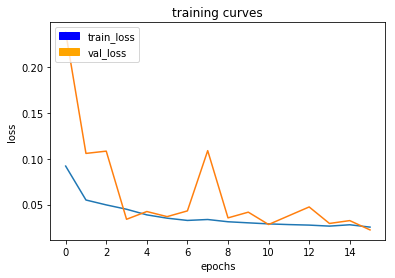

103/103 [==============================] - 67s - loss: 0.0254 - val_loss: 0.0223
Epoch 17/100
102/103 [============================>.] - ETA: 0s - loss: 0.0244

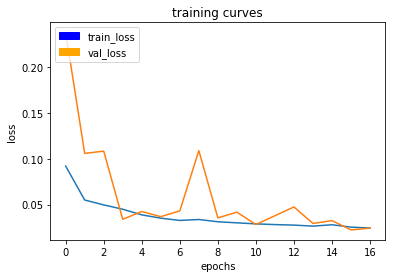

103/103 [==============================] - 67s - loss: 0.0244 - val_loss: 0.0243
Epoch 18/100
102/103 [============================>.] - ETA: 0s - loss: 0.0243

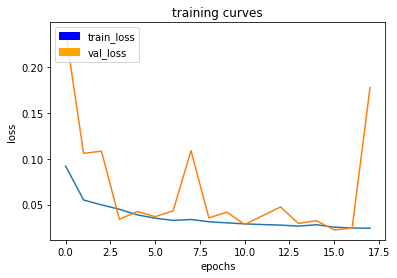

103/103 [==============================] - 67s - loss: 0.0242 - val_loss: 0.1780
Epoch 19/100
102/103 [============================>.] - ETA: 0s - loss: 0.0240

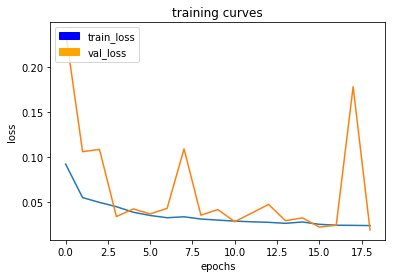

103/103 [==============================] - 67s - loss: 0.0240 - val_loss: 0.0192
Epoch 20/100
102/103 [============================>.] - ETA: 0s - loss: 0.0240

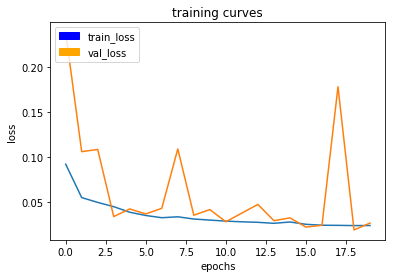

Epoch 00019: saving model to ./model-checkpoint/weights-e19-0.03.hdf5
103/103 [==============================] - 67s - loss: 0.0240 - val_loss: 0.0268
Epoch 21/100
102/103 [============================>.] - ETA: 0s - loss: 0.0227

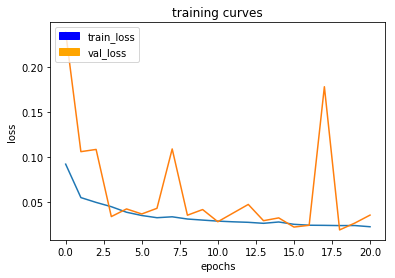

103/103 [==============================] - 67s - loss: 0.0227 - val_loss: 0.0356
Epoch 22/100
102/103 [============================>.] - ETA: 0s - loss: 0.0232

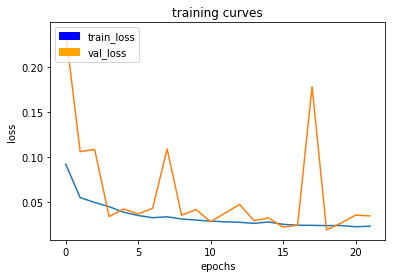

103/103 [==============================] - 67s - loss: 0.0232 - val_loss: 0.0347
Epoch 23/100
102/103 [============================>.] - ETA: 0s - loss: 0.0233

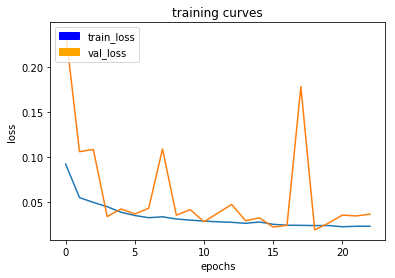

103/103 [==============================] - 67s - loss: 0.0233 - val_loss: 0.0366
Epoch 24/100
102/103 [============================>.] - ETA: 0s - loss: 0.0229

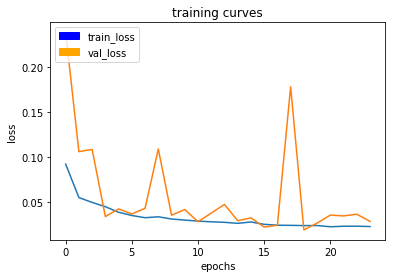

103/103 [==============================] - 66s - loss: 0.0229 - val_loss: 0.0286
Epoch 25/100
102/103 [============================>.] - ETA: 0s - loss: 0.0217

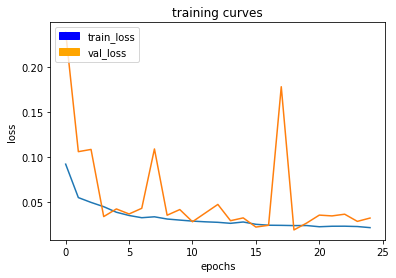

Epoch 00024: saving model to ./model-checkpoint/weights-e24-0.03.hdf5
103/103 [==============================] - 68s - loss: 0.0217 - val_loss: 0.0323
Epoch 26/100
102/103 [============================>.] - ETA: 0s - loss: 0.0214

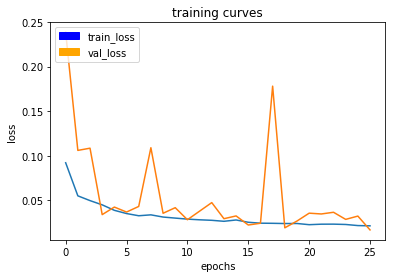

103/103 [==============================] - 67s - loss: 0.0214 - val_loss: 0.0168
Epoch 27/100
102/103 [============================>.] - ETA: 0s - loss: 0.0211

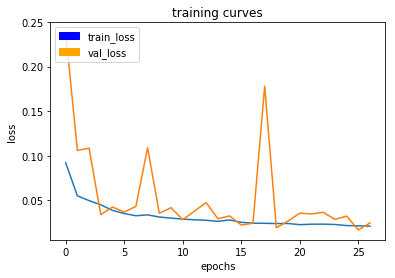

103/103 [==============================] - 67s - loss: 0.0211 - val_loss: 0.0247
Epoch 28/100
102/103 [============================>.] - ETA: 0s - loss: 0.0221

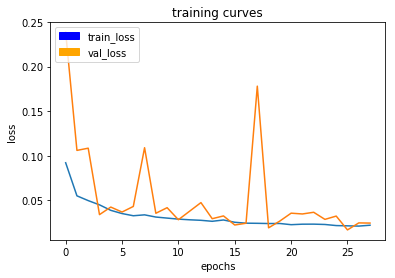

103/103 [==============================] - 67s - loss: 0.0221 - val_loss: 0.0245
Epoch 29/100
102/103 [============================>.] - ETA: 0s - loss: 0.0209

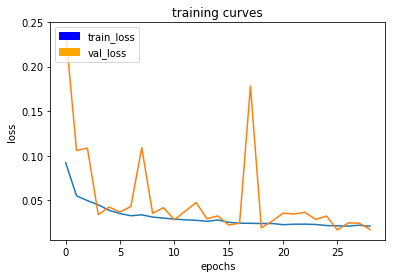

103/103 [==============================] - 67s - loss: 0.0210 - val_loss: 0.0173
Epoch 30/100
102/103 [============================>.] - ETA: 0s - loss: 0.0204

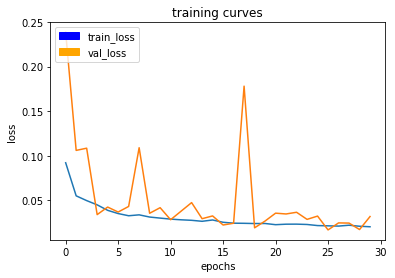

Epoch 00029: saving model to ./model-checkpoint/weights-e29-0.03.hdf5
103/103 [==============================] - 67s - loss: 0.0204 - val_loss: 0.0318
Epoch 31/100
102/103 [============================>.] - ETA: 0s - loss: 0.0212

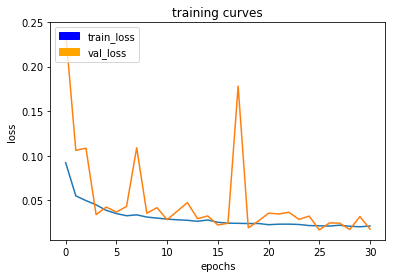

103/103 [==============================] - 68s - loss: 0.0212 - val_loss: 0.0177
Epoch 32/100
102/103 [============================>.] - ETA: 0s - loss: 0.0221

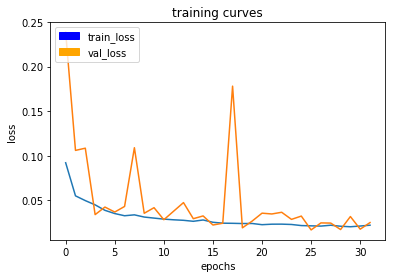

103/103 [==============================] - 67s - loss: 0.0221 - val_loss: 0.0251
Epoch 33/100
102/103 [============================>.] - ETA: 0s - loss: 0.0212

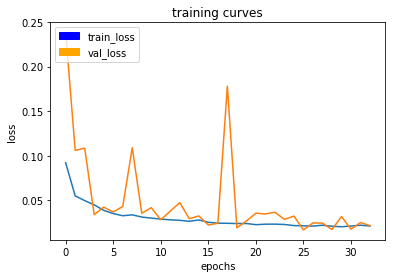

103/103 [==============================] - 67s - loss: 0.0212 - val_loss: 0.0216
Epoch 34/100
102/103 [============================>.] - ETA: 0s - loss: 0.0202

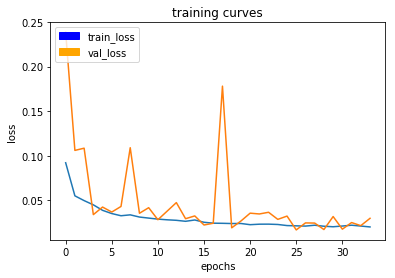

103/103 [==============================] - 68s - loss: 0.0202 - val_loss: 0.0298
Epoch 35/100
102/103 [============================>.] - ETA: 0s - loss: 0.0196

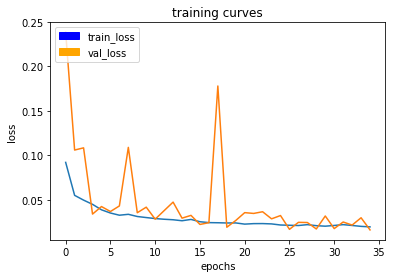

Epoch 00034: saving model to ./model-checkpoint/weights-e34-0.02.hdf5
103/103 [==============================] - 66s - loss: 0.0196 - val_loss: 0.0162
Epoch 36/100
102/103 [============================>.] - ETA: 0s - loss: 0.0196

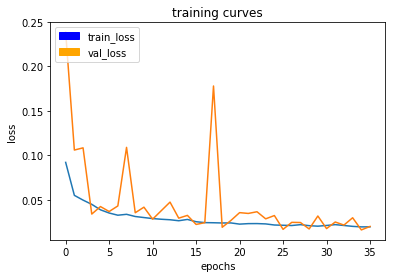

103/103 [==============================] - 67s - loss: 0.0196 - val_loss: 0.0201
Epoch 37/100
102/103 [============================>.] - ETA: 0s - loss: 0.0193

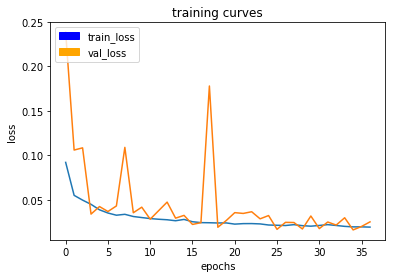

103/103 [==============================] - 66s - loss: 0.0193 - val_loss: 0.0252
Epoch 38/100
102/103 [============================>.] - ETA: 0s - loss: 0.0199

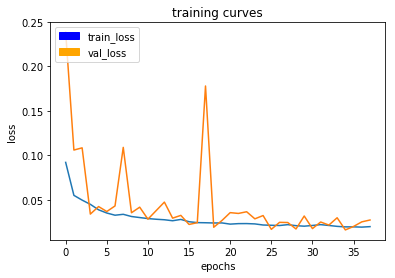

103/103 [==============================] - 67s - loss: 0.0199 - val_loss: 0.0273
Epoch 39/100
102/103 [============================>.] - ETA: 0s - loss: 0.0192

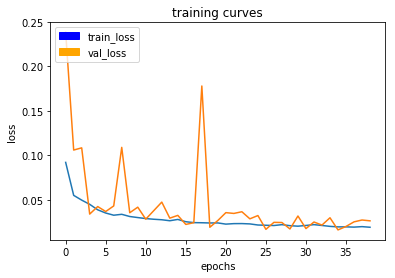

103/103 [==============================] - 67s - loss: 0.0192 - val_loss: 0.0264
Epoch 40/100
102/103 [============================>.] - ETA: 0s - loss: 0.0194

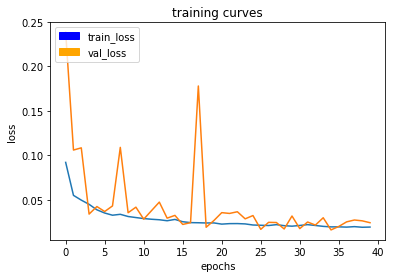

Epoch 00039: saving model to ./model-checkpoint/weights-e39-0.02.hdf5
103/103 [==============================] - 67s - loss: 0.0194 - val_loss: 0.0243
Epoch 41/100
102/103 [============================>.] - ETA: 0s - loss: 0.0186

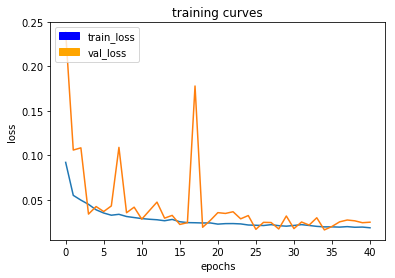

103/103 [==============================] - 68s - loss: 0.0186 - val_loss: 0.0249
Epoch 42/100
102/103 [============================>.] - ETA: 0s - loss: 0.0185

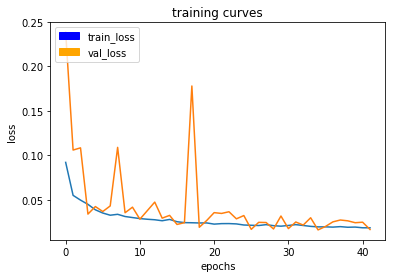

103/103 [==============================] - 67s - loss: 0.0186 - val_loss: 0.0167
Epoch 43/100
102/103 [============================>.] - ETA: 0s - loss: 0.0183

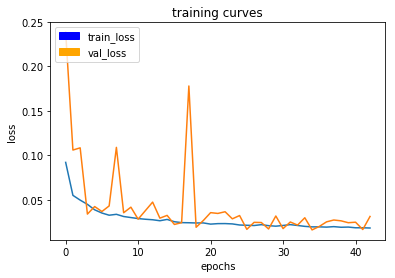

103/103 [==============================] - 67s - loss: 0.0183 - val_loss: 0.0313
Epoch 44/100
102/103 [============================>.] - ETA: 0s - loss: 0.0181

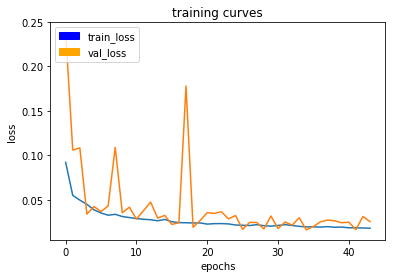

103/103 [==============================] - 67s - loss: 0.0181 - val_loss: 0.0255
Epoch 45/100
102/103 [============================>.] - ETA: 0s - loss: 0.0201

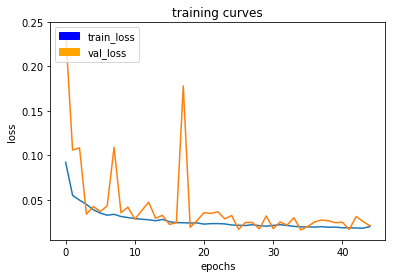

Epoch 00044: saving model to ./model-checkpoint/weights-e44-0.02.hdf5
103/103 [==============================] - 67s - loss: 0.0201 - val_loss: 0.0208
Epoch 46/100
102/103 [============================>.] - ETA: 0s - loss: 0.0200

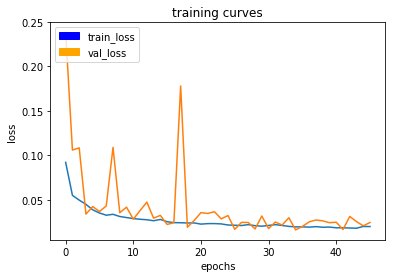

103/103 [==============================] - 67s - loss: 0.0200 - val_loss: 0.0245
Epoch 47/100
102/103 [============================>.] - ETA: 0s - loss: 0.0186

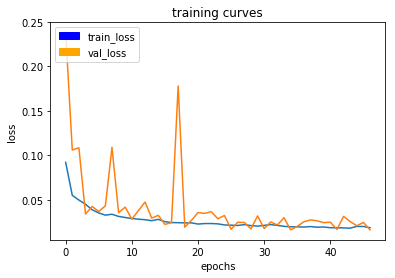

103/103 [==============================] - 67s - loss: 0.0186 - val_loss: 0.0161
Epoch 48/100
102/103 [============================>.] - ETA: 0s - loss: 0.0187

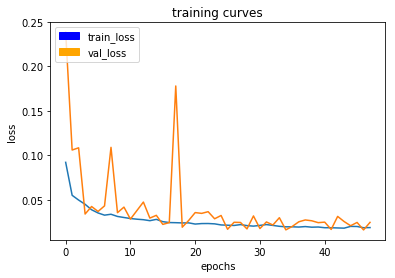

103/103 [==============================] - 68s - loss: 0.0187 - val_loss: 0.0246
Epoch 49/100
102/103 [============================>.] - ETA: 0s - loss: 0.0182

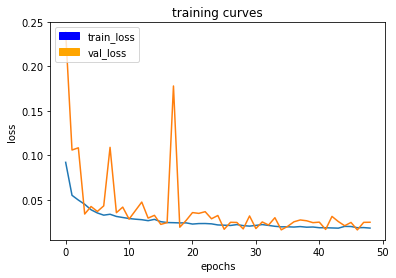

103/103 [==============================] - 67s - loss: 0.0182 - val_loss: 0.0247
Epoch 50/100
102/103 [============================>.] - ETA: 0s - loss: 0.0178

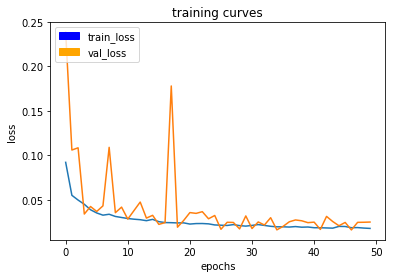

Epoch 00049: saving model to ./model-checkpoint/weights-e49-0.02.hdf5
103/103 [==============================] - 67s - loss: 0.0178 - val_loss: 0.0249
Epoch 51/100
102/103 [============================>.] - ETA: 0s - loss: 0.0175

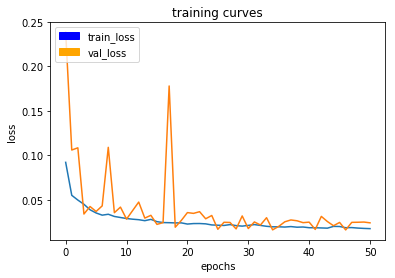

103/103 [==============================] - 67s - loss: 0.0175 - val_loss: 0.0241
Epoch 52/100
102/103 [============================>.] - ETA: 0s - loss: 0.0174

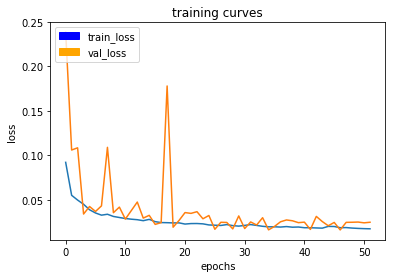

103/103 [==============================] - 67s - loss: 0.0174 - val_loss: 0.0247
Epoch 53/100
102/103 [============================>.] - ETA: 0s - loss: 0.0173

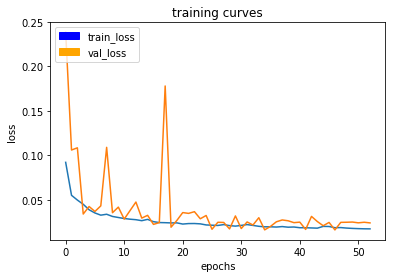

103/103 [==============================] - 67s - loss: 0.0173 - val_loss: 0.0240
Epoch 54/100
102/103 [============================>.] - ETA: 0s - loss: 0.0172

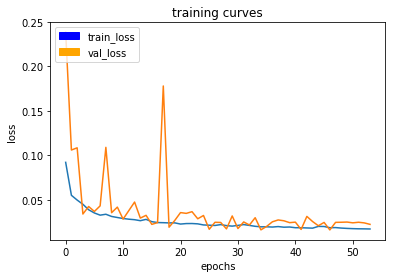

103/103 [==============================] - 67s - loss: 0.0172 - val_loss: 0.0224
Epoch 55/100
102/103 [============================>.] - ETA: 0s - loss: 0.0172

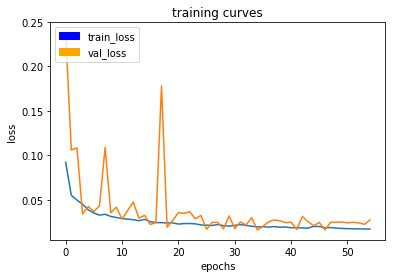

Epoch 00054: saving model to ./model-checkpoint/weights-e54-0.03.hdf5
103/103 [==============================] - 67s - loss: 0.0171 - val_loss: 0.0273
Epoch 56/100
102/103 [============================>.] - ETA: 0s - loss: 0.0172

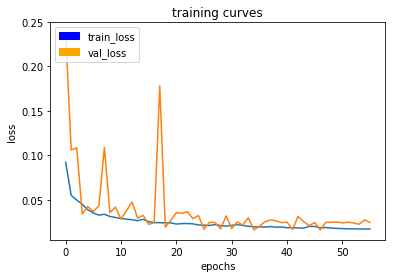

103/103 [==============================] - 67s - loss: 0.0172 - val_loss: 0.0246
Epoch 57/100
102/103 [============================>.] - ETA: 0s - loss: 0.0170

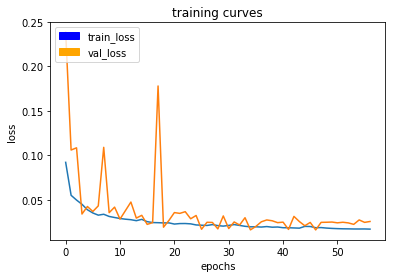

103/103 [==============================] - 67s - loss: 0.0170 - val_loss: 0.0256
Epoch 58/100
102/103 [============================>.] - ETA: 0s - loss: 0.0171

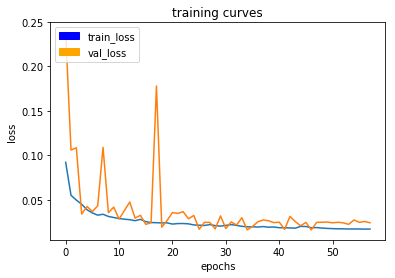

103/103 [==============================] - 67s - loss: 0.0171 - val_loss: 0.0242
Epoch 59/100
102/103 [============================>.] - ETA: 0s - loss: 0.0170

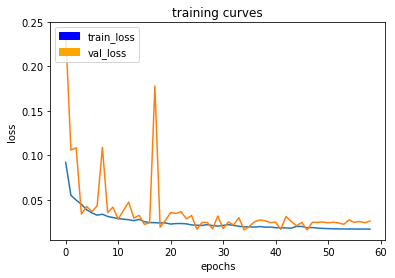

103/103 [==============================] - 66s - loss: 0.0170 - val_loss: 0.0261
Epoch 60/100
102/103 [============================>.] - ETA: 0s - loss: 0.0168

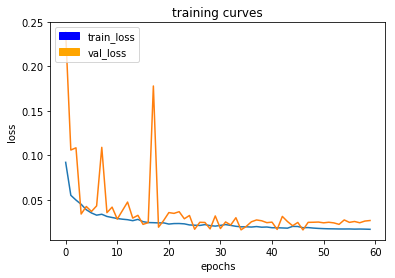

Epoch 00059: saving model to ./model-checkpoint/weights-e59-0.03.hdf5
103/103 [==============================] - 67s - loss: 0.0168 - val_loss: 0.0267
Epoch 61/100
102/103 [============================>.] - ETA: 0s - loss: 0.0188

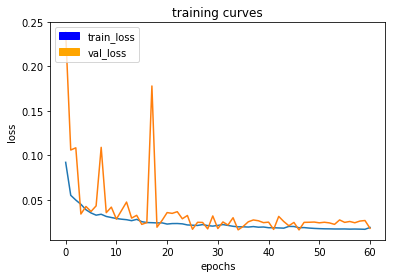

103/103 [==============================] - 67s - loss: 0.0188 - val_loss: 0.0179
Epoch 62/100
102/103 [============================>.] - ETA: 0s - loss: 0.0181

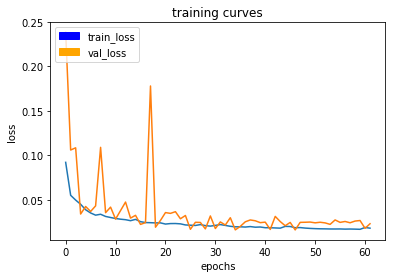

103/103 [==============================] - 67s - loss: 0.0181 - val_loss: 0.0231
Epoch 63/100
102/103 [============================>.] - ETA: 0s - loss: 0.0180

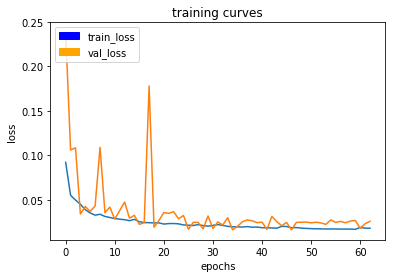

103/103 [==============================] - 66s - loss: 0.0180 - val_loss: 0.0258
Epoch 64/100
102/103 [============================>.] - ETA: 0s - loss: 0.0173

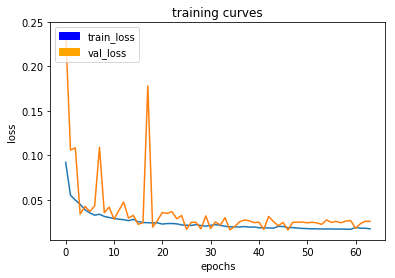

103/103 [==============================] - 67s - loss: 0.0173 - val_loss: 0.0258
Epoch 65/100
102/103 [============================>.] - ETA: 0s - loss: 0.0169

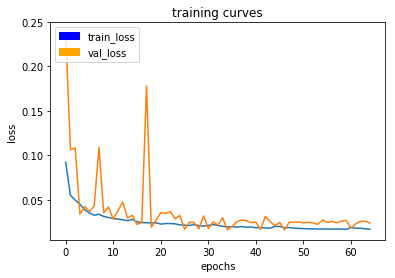

Epoch 00064: saving model to ./model-checkpoint/weights-e64-0.02.hdf5
103/103 [==============================] - 67s - loss: 0.0169 - val_loss: 0.0238
Epoch 66/100
102/103 [============================>.] - ETA: 0s - loss: 0.0169

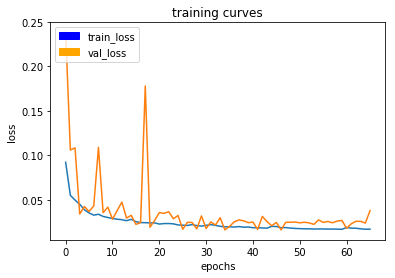

103/103 [==============================] - 67s - loss: 0.0169 - val_loss: 0.0378
Epoch 67/100
102/103 [============================>.] - ETA: 0s - loss: 0.0175

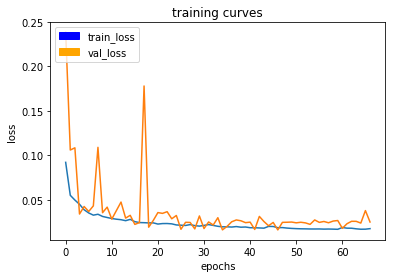

103/103 [==============================] - 67s - loss: 0.0175 - val_loss: 0.0250
Epoch 68/100
102/103 [============================>.] - ETA: 0s - loss: 0.0167

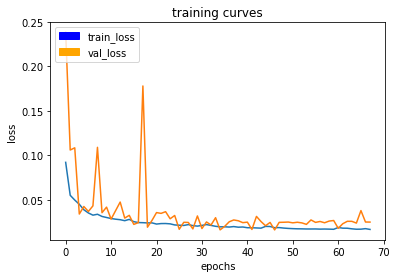

103/103 [==============================] - 67s - loss: 0.0167 - val_loss: 0.0249
Epoch 69/100
102/103 [============================>.] - ETA: 0s - loss: 0.0165

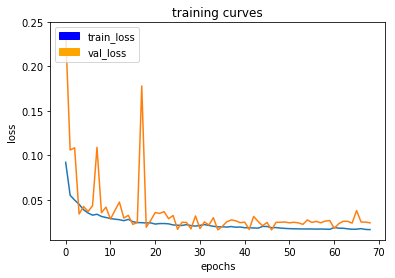

103/103 [==============================] - 67s - loss: 0.0165 - val_loss: 0.0240
Epoch 70/100
102/103 [============================>.] - ETA: 0s - loss: 0.0164

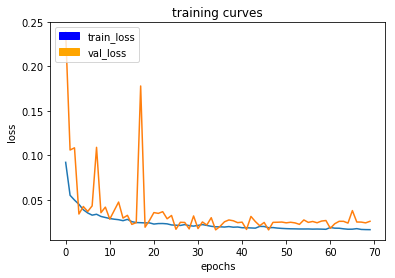

Epoch 00069: saving model to ./model-checkpoint/weights-e69-0.03.hdf5
103/103 [==============================] - 67s - loss: 0.0164 - val_loss: 0.0258
Epoch 71/100
102/103 [============================>.] - ETA: 0s - loss: 0.0162

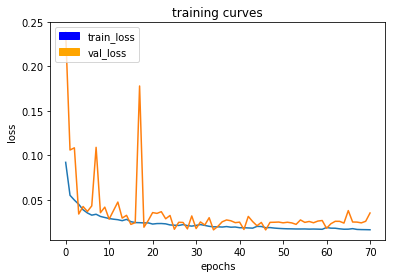

103/103 [==============================] - 67s - loss: 0.0163 - val_loss: 0.0351
Epoch 72/100
102/103 [============================>.] - ETA: 0s - loss: 0.0163

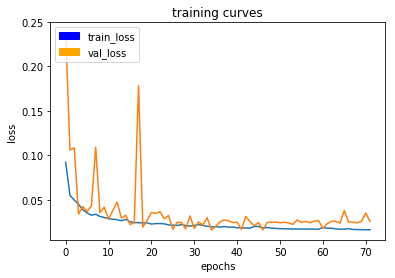

103/103 [==============================] - 67s - loss: 0.0163 - val_loss: 0.0257
Epoch 73/100
102/103 [============================>.] - ETA: 0s - loss: 0.0165

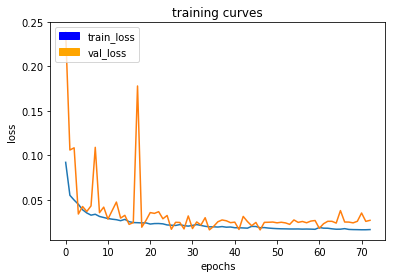

103/103 [==============================] - 67s - loss: 0.0165 - val_loss: 0.0269
Epoch 74/100
102/103 [============================>.] - ETA: 0s - loss: 0.0162

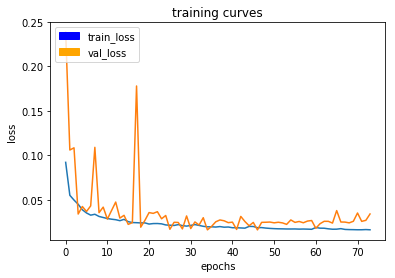

103/103 [==============================] - 67s - loss: 0.0163 - val_loss: 0.0340
Epoch 75/100
102/103 [============================>.] - ETA: 0s - loss: 0.0162

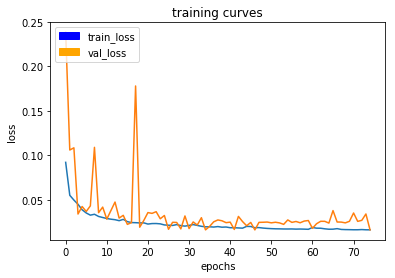

Epoch 00074: saving model to ./model-checkpoint/weights-e74-0.02.hdf5
103/103 [==============================] - 67s - loss: 0.0162 - val_loss: 0.0162
Epoch 76/100
102/103 [============================>.] - ETA: 0s - loss: 0.0164

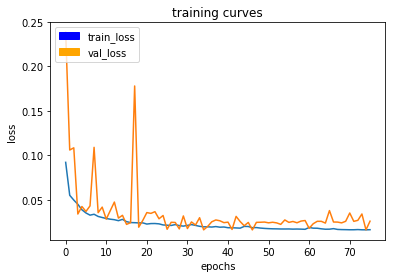

103/103 [==============================] - 67s - loss: 0.0164 - val_loss: 0.0259
Epoch 77/100
102/103 [============================>.] - ETA: 0s - loss: 0.0164

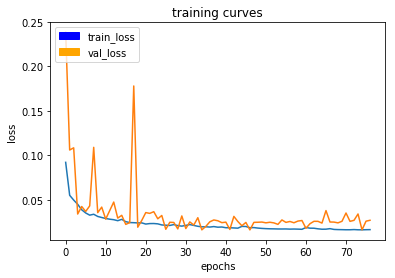

103/103 [==============================] - 66s - loss: 0.0164 - val_loss: 0.0269
Epoch 78/100
102/103 [============================>.] - ETA: 0s - loss: 0.0162

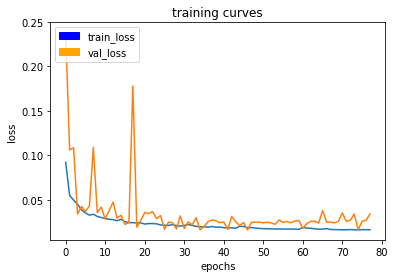

103/103 [==============================] - 67s - loss: 0.0162 - val_loss: 0.0340
Epoch 79/100
102/103 [============================>.] - ETA: 0s - loss: 0.0162

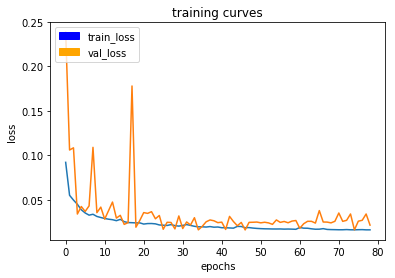

103/103 [==============================] - 66s - loss: 0.0162 - val_loss: 0.0215
Epoch 80/100
102/103 [============================>.] - ETA: 0s - loss: 0.0164

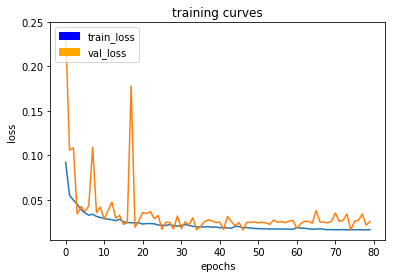

Epoch 00079: saving model to ./model-checkpoint/weights-e79-0.03.hdf5
103/103 [==============================] - 66s - loss: 0.0164 - val_loss: 0.0257
Epoch 81/100
102/103 [============================>.] - ETA: 0s - loss: 0.0160

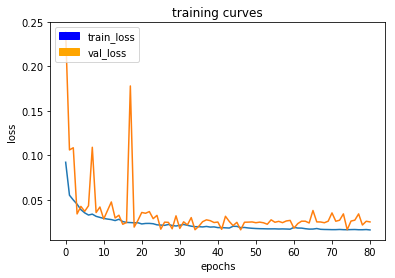

103/103 [==============================] - 67s - loss: 0.0160 - val_loss: 0.0250
Epoch 82/100
102/103 [============================>.] - ETA: 0s - loss: 0.0160

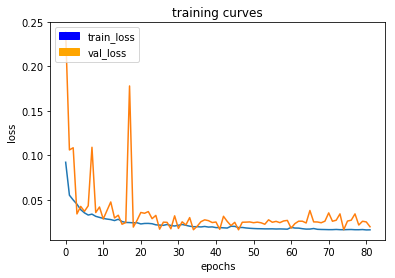

103/103 [==============================] - 66s - loss: 0.0161 - val_loss: 0.0195
Epoch 83/100
102/103 [============================>.] - ETA: 0s - loss: 0.0158

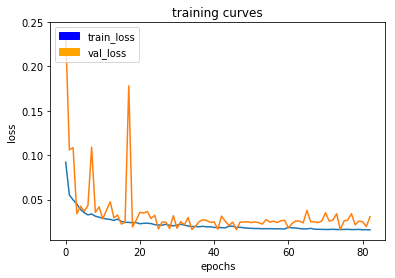

103/103 [==============================] - 67s - loss: 0.0158 - val_loss: 0.0307
Epoch 84/100
102/103 [============================>.] - ETA: 0s - loss: 0.0158

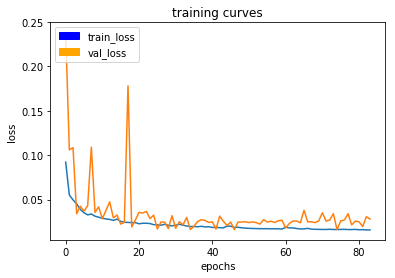

103/103 [==============================] - 67s - loss: 0.0158 - val_loss: 0.0280
Epoch 85/100
102/103 [============================>.] - ETA: 0s - loss: 0.0157

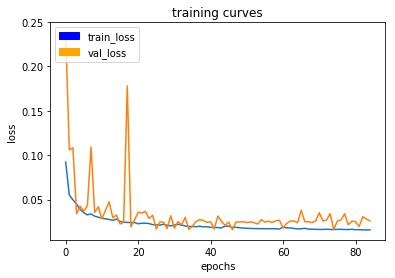

Epoch 00084: saving model to ./model-checkpoint/weights-e84-0.03.hdf5
103/103 [==============================] - 68s - loss: 0.0157 - val_loss: 0.0258
Epoch 86/100
102/103 [============================>.] - ETA: 0s - loss: 0.0158

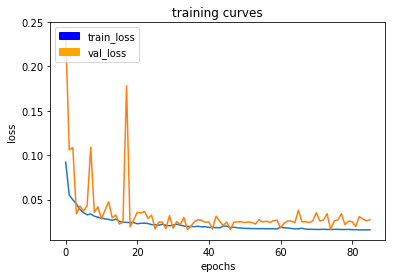

103/103 [==============================] - 66s - loss: 0.0158 - val_loss: 0.0273
Epoch 87/100
102/103 [============================>.] - ETA: 0s - loss: 0.0158

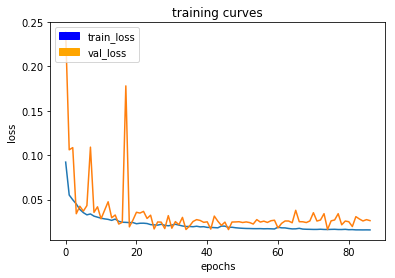

103/103 [==============================] - 67s - loss: 0.0157 - val_loss: 0.0262
Epoch 88/100
102/103 [============================>.] - ETA: 0s - loss: 0.0157

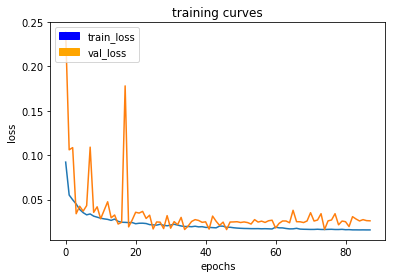

103/103 [==============================] - 66s - loss: 0.0157 - val_loss: 0.0260
Epoch 89/100
102/103 [============================>.] - ETA: 0s - loss: 0.0157

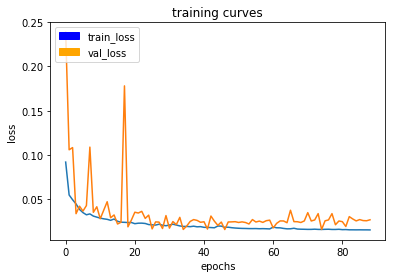

103/103 [==============================] - 66s - loss: 0.0157 - val_loss: 0.0271
Epoch 90/100
102/103 [============================>.] - ETA: 0s - loss: 0.0157

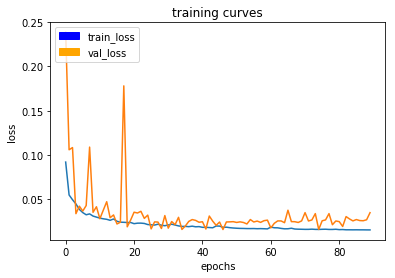

Epoch 00089: saving model to ./model-checkpoint/weights-e89-0.04.hdf5
103/103 [==============================] - 67s - loss: 0.0156 - val_loss: 0.0351
Epoch 91/100
102/103 [============================>.] - ETA: 0s - loss: 0.0157

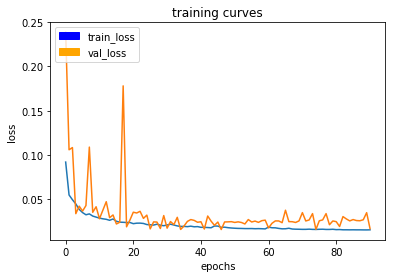

103/103 [==============================] - 67s - loss: 0.0158 - val_loss: 0.0171
Epoch 92/100
102/103 [============================>.] - ETA: 0s - loss: 0.0156

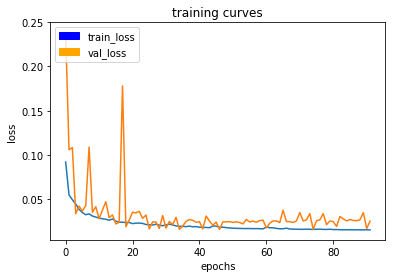

103/103 [==============================] - 67s - loss: 0.0156 - val_loss: 0.0256
Epoch 93/100
102/103 [============================>.] - ETA: 0s - loss: 0.0157

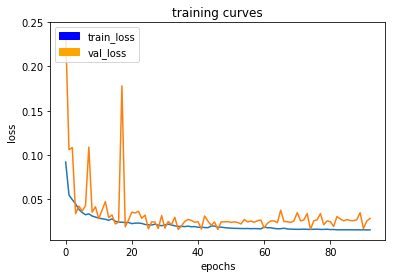

103/103 [==============================] - 66s - loss: 0.0156 - val_loss: 0.0287
Epoch 94/100
102/103 [============================>.] - ETA: 0s - loss: 0.0156

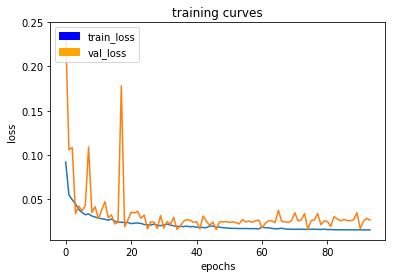

103/103 [==============================] - 67s - loss: 0.0156 - val_loss: 0.0266
Epoch 95/100
102/103 [============================>.] - ETA: 0s - loss: 0.0156

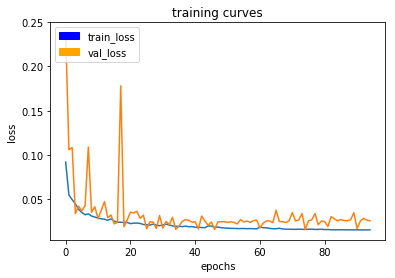

Epoch 00094: saving model to ./model-checkpoint/weights-e94-0.03.hdf5
103/103 [==============================] - 67s - loss: 0.0156 - val_loss: 0.0258
Epoch 96/100
102/103 [============================>.] - ETA: 0s - loss: 0.0156

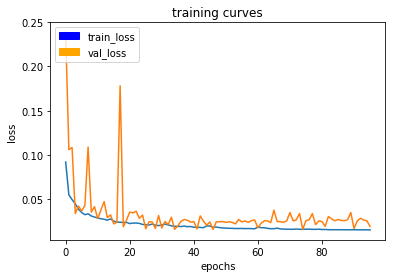

103/103 [==============================] - 67s - loss: 0.0155 - val_loss: 0.0196
Epoch 97/100
102/103 [============================>.] - ETA: 0s - loss: 0.0180

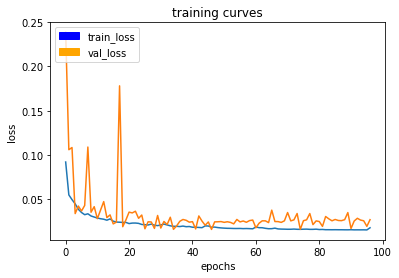

103/103 [==============================] - 66s - loss: 0.0179 - val_loss: 0.0271
Epoch 98/100
102/103 [============================>.] - ETA: 0s - loss: 0.0161

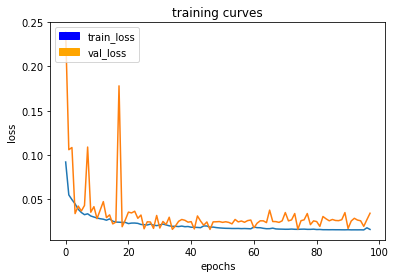

103/103 [==============================] - 66s - loss: 0.0161 - val_loss: 0.0343
Epoch 99/100
102/103 [============================>.] - ETA: 0s - loss: 0.0172

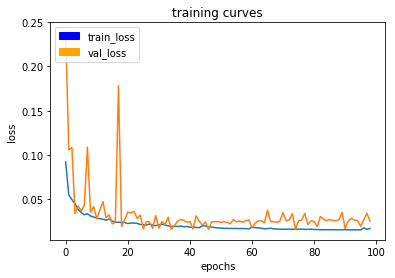

103/103 [==============================] - 67s - loss: 0.0172 - val_loss: 0.0253
Epoch 100/100
102/103 [============================>.] - ETA: 0s - loss: 0.0161

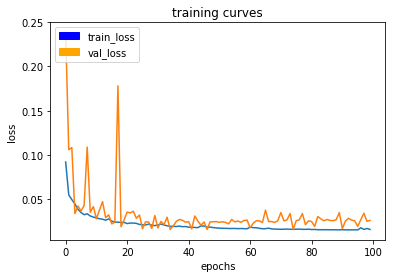

Epoch 00099: saving model to ./model-checkpoint/weights-e99-0.03.hdf5
103/103 [==============================] - 67s - loss: 0.0161 - val_loss: 0.0262


In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, decay=decay_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
save_cb = keras.callbacks.ModelCheckpoint(filepath='./model-checkpoint/weights-e{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, period=5)
callbacks = [logger_cb, save_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [30]:
# Save your trained model weights
weight_file_name = 'weights-e49-0.02.hdf5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [31]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [32]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

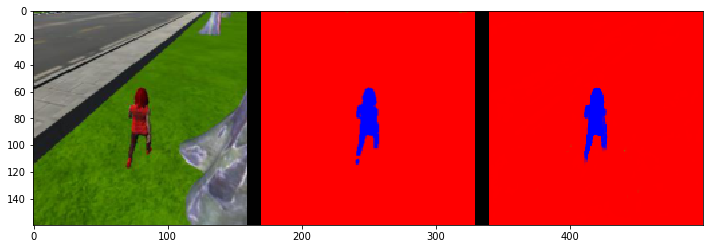

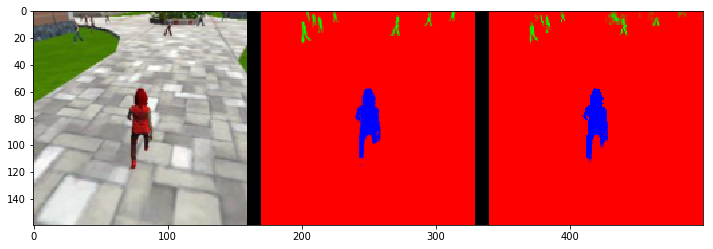

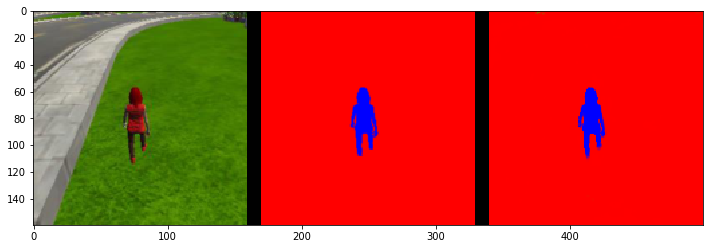

In [33]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

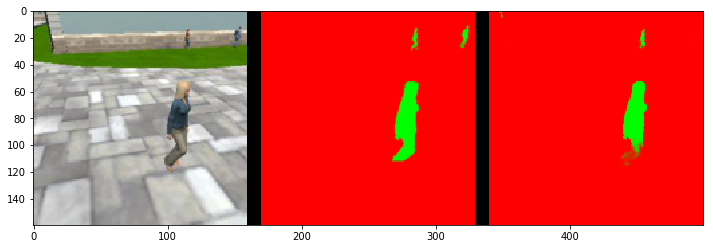

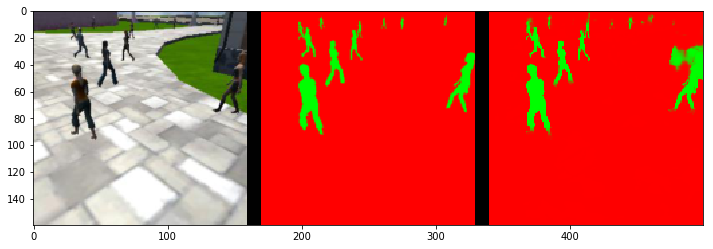

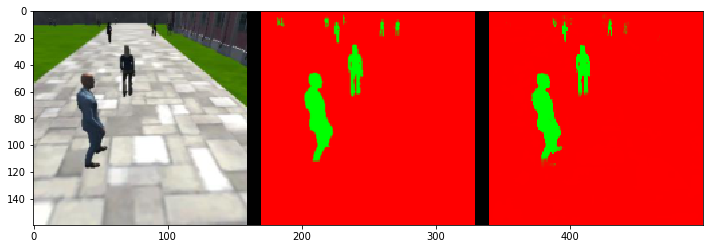

In [34]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

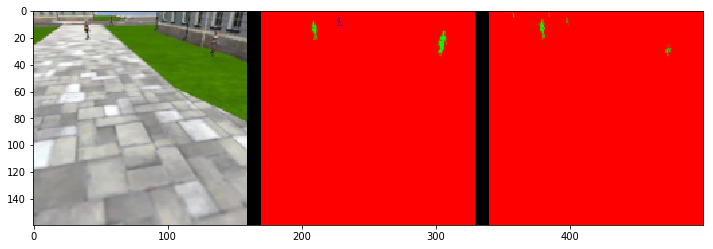

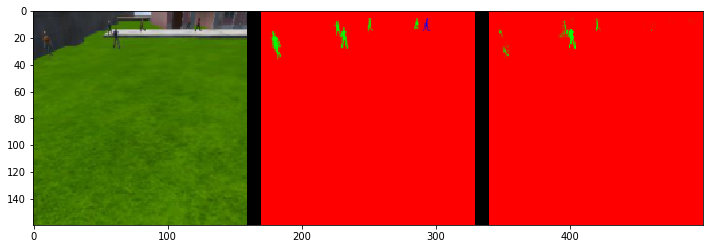

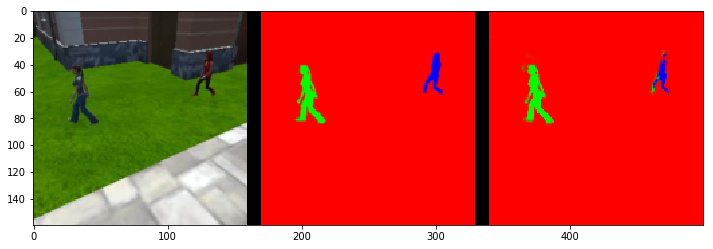

In [35]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [36]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.996553196263672
average intersection over union for other people is 0.40461329744064833
average intersection over union for the hero is 0.9224038199630111
number true positives: 539, number false positives: 0, number false negatives: 0


In [37]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9932521143874394
average intersection over union for other people is 0.865000320101974
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 9, number false negatives: 0


In [38]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9973085758577057
average intersection over union for other people is 0.4896831832246824
average intersection over union for the hero is 0.26062944484167594
number true positives: 132, number false positives: 1, number false negatives: 169


In [39]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7894117647058824


In [40]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.591516632402


In [41]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.466950188638
